## Laboratorio en clases<a class="tocSkip">
## EL453 ELECTIVA I - Deep Learning <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
**joseiglesias@unicesar.edu.co**# 

# Ejercicio Machine Learning: Gaussian Naive Bayes

## ¿Comprar o alquilar casa? ¿Qué me conviene?

La explicacion completa en el blog www.aprendemachinelearning.com

En este ejercicio, usaremos el algoritmo de Gaussian Naive Bayes para decidir si nos conviene Alguilar o Comprar una casa 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest

## Importemos Datos de entrada

In [2]:
dataframe = pd.read_csv(r"comprar_alquilar.csv")
dataframe.head(10)
# REFERENCIAS:
# ingresos y gastos son mensuales de 1 personas o 2 si están casados.
# trabajo: 0-sin trabajo 1-autonomo 2-asalariado 3-empresario 4-Autonomos 5-Asalariados 6-Autonomo y Asalariado 7-Empresario y Autonomo 8 Empresarios o empresario y autónomo
# estado_civil: 0-soltero 1-casado 2-divorciado
# hijos: Cantidad de hijos menores (no trabajan)
# comprar: 0-mejor alquilar 1-Comprar casa
# hipoteca fija a 30 años con interes

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


In [3]:
print(dataframe.groupby('comprar').size())

comprar
0    135
1     67
dtype: int64


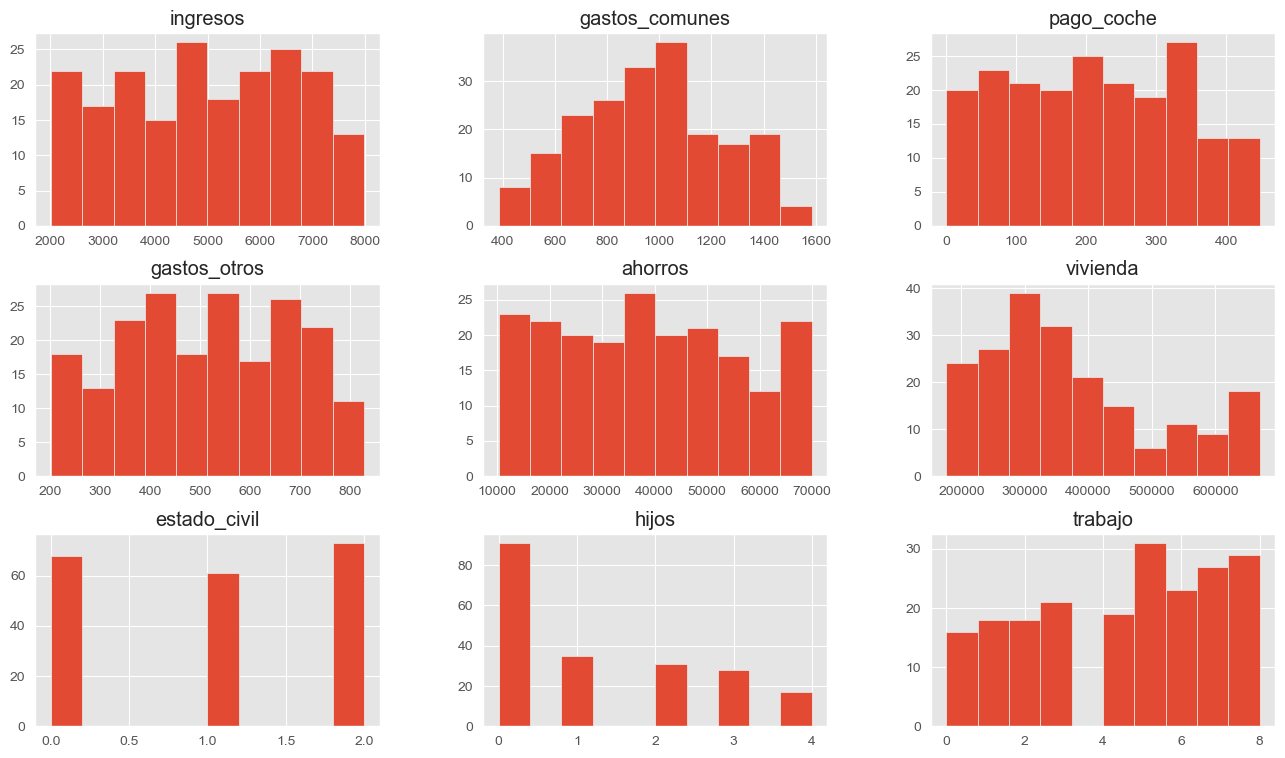

In [4]:
dataframe.drop(['comprar'], axis=1).hist()
plt.show()

# Preprocesamos los datos

Creamos 2 columnas nuevas. En una agrupamos los gastos mensuales. En la otra el monto a financiar para comprar la casa

In [5]:
dataframe['gastos']=(dataframe['gastos_comunes']+dataframe['gastos_otros']+dataframe['pago_coche'])
dataframe['financiar']=dataframe['vivienda']-dataframe['ahorros']
dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1).head(10)

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
0,6000,50000,400000,0,2,2,1,1600,350000
1,6745,43240,636897,1,3,6,0,1496,593657
2,6455,57463,321779,2,1,8,1,1926,264316
3,7098,54506,660933,0,0,3,0,1547,606427
4,6167,41512,348932,0,0,3,1,1606,307420
5,5692,50875,360863,1,4,5,1,1247,309988
6,6830,46761,429812,1,1,5,1,1952,383051
7,6470,57439,606291,0,0,1,0,1856,548852
8,6251,50503,291010,0,0,3,1,2030,240507
9,6987,40611,324098,2,1,7,1,1755,283487


### Información estadística de los datos

In [6]:
reduced = dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1)
reduced.describe()

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,38749.668317,373349.638614,1.024752,1.232673,4.490099,0.331683,1698.752475,334599.970297
std,1682.862556,17365.231870,136371.525622,0.837184,1.367833,2.535794,0.471988,324.838005,126607.099497
min,2008.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,154716.000000
25%,3513.750000,24964.250000,274810.000000,0.000000,0.000000,2.000000,0.000000,1430.500000,240410.250000
50%,4947.500000,38523.000000,340783.500000,1.000000,1.000000,5.000000,0.000000,1669.500000,301177.000000
75%,6374.500000,52150.750000,444482.000000,2.000000,2.000000,7.000000,1.000000,1928.000000,393413.000000
max,7984.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000,2543.000000,618621.000000


## Feature Selection
Selección de las características de entrada.

### Veamos la correlación entre columnas

<Axes: title={'center': 'Pearson Correlation of Features'}>

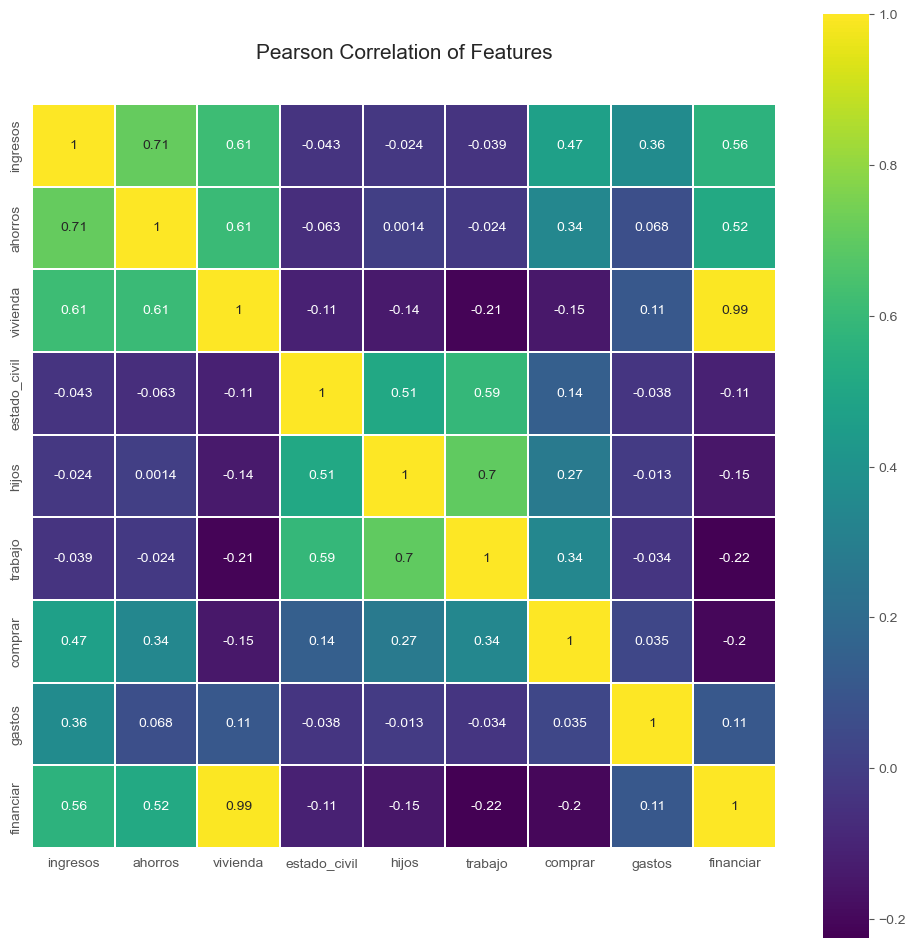

In [7]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(reduced.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Usemos la clase SelectKBest de SkLearn para elegir las 5 mejores características a usar.

In [8]:
X=dataframe.drop(['comprar'], axis=1)
y=dataframe['comprar']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar'], dtype='object')


Veamos la correlación entre las 5 mejores Features

<Axes: title={'center': 'Pearson Correlation of Features'}>

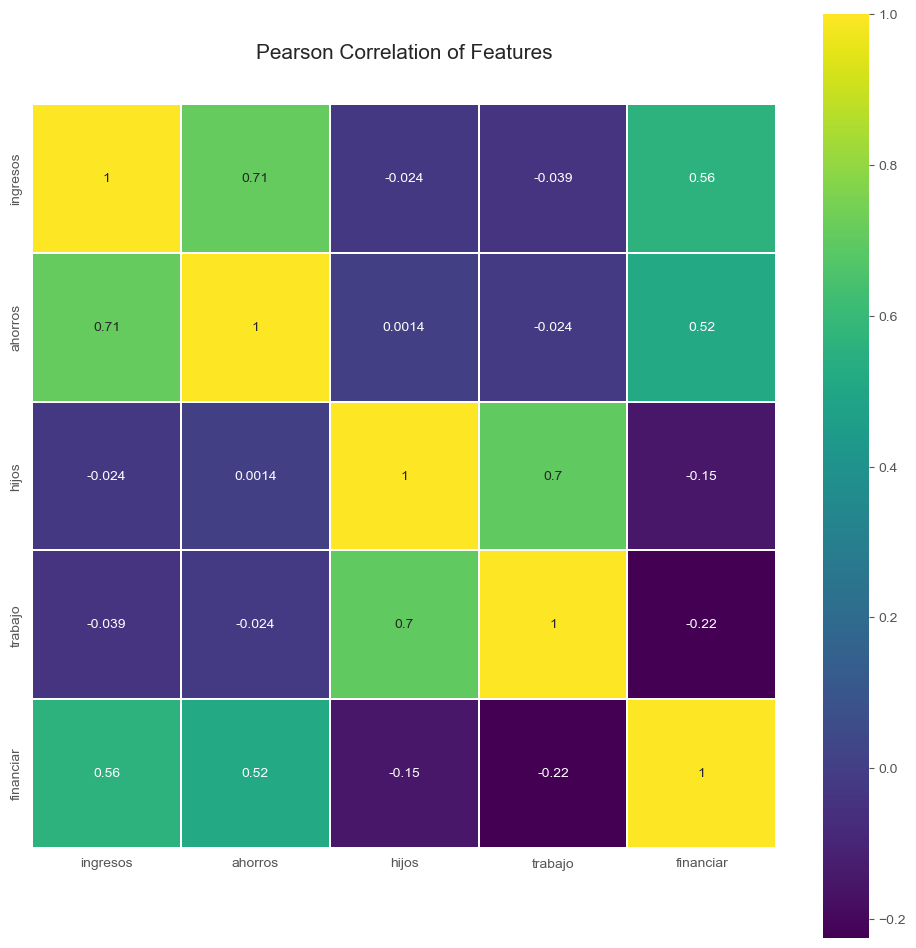

In [9]:
used_features =X.columns[selected]

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

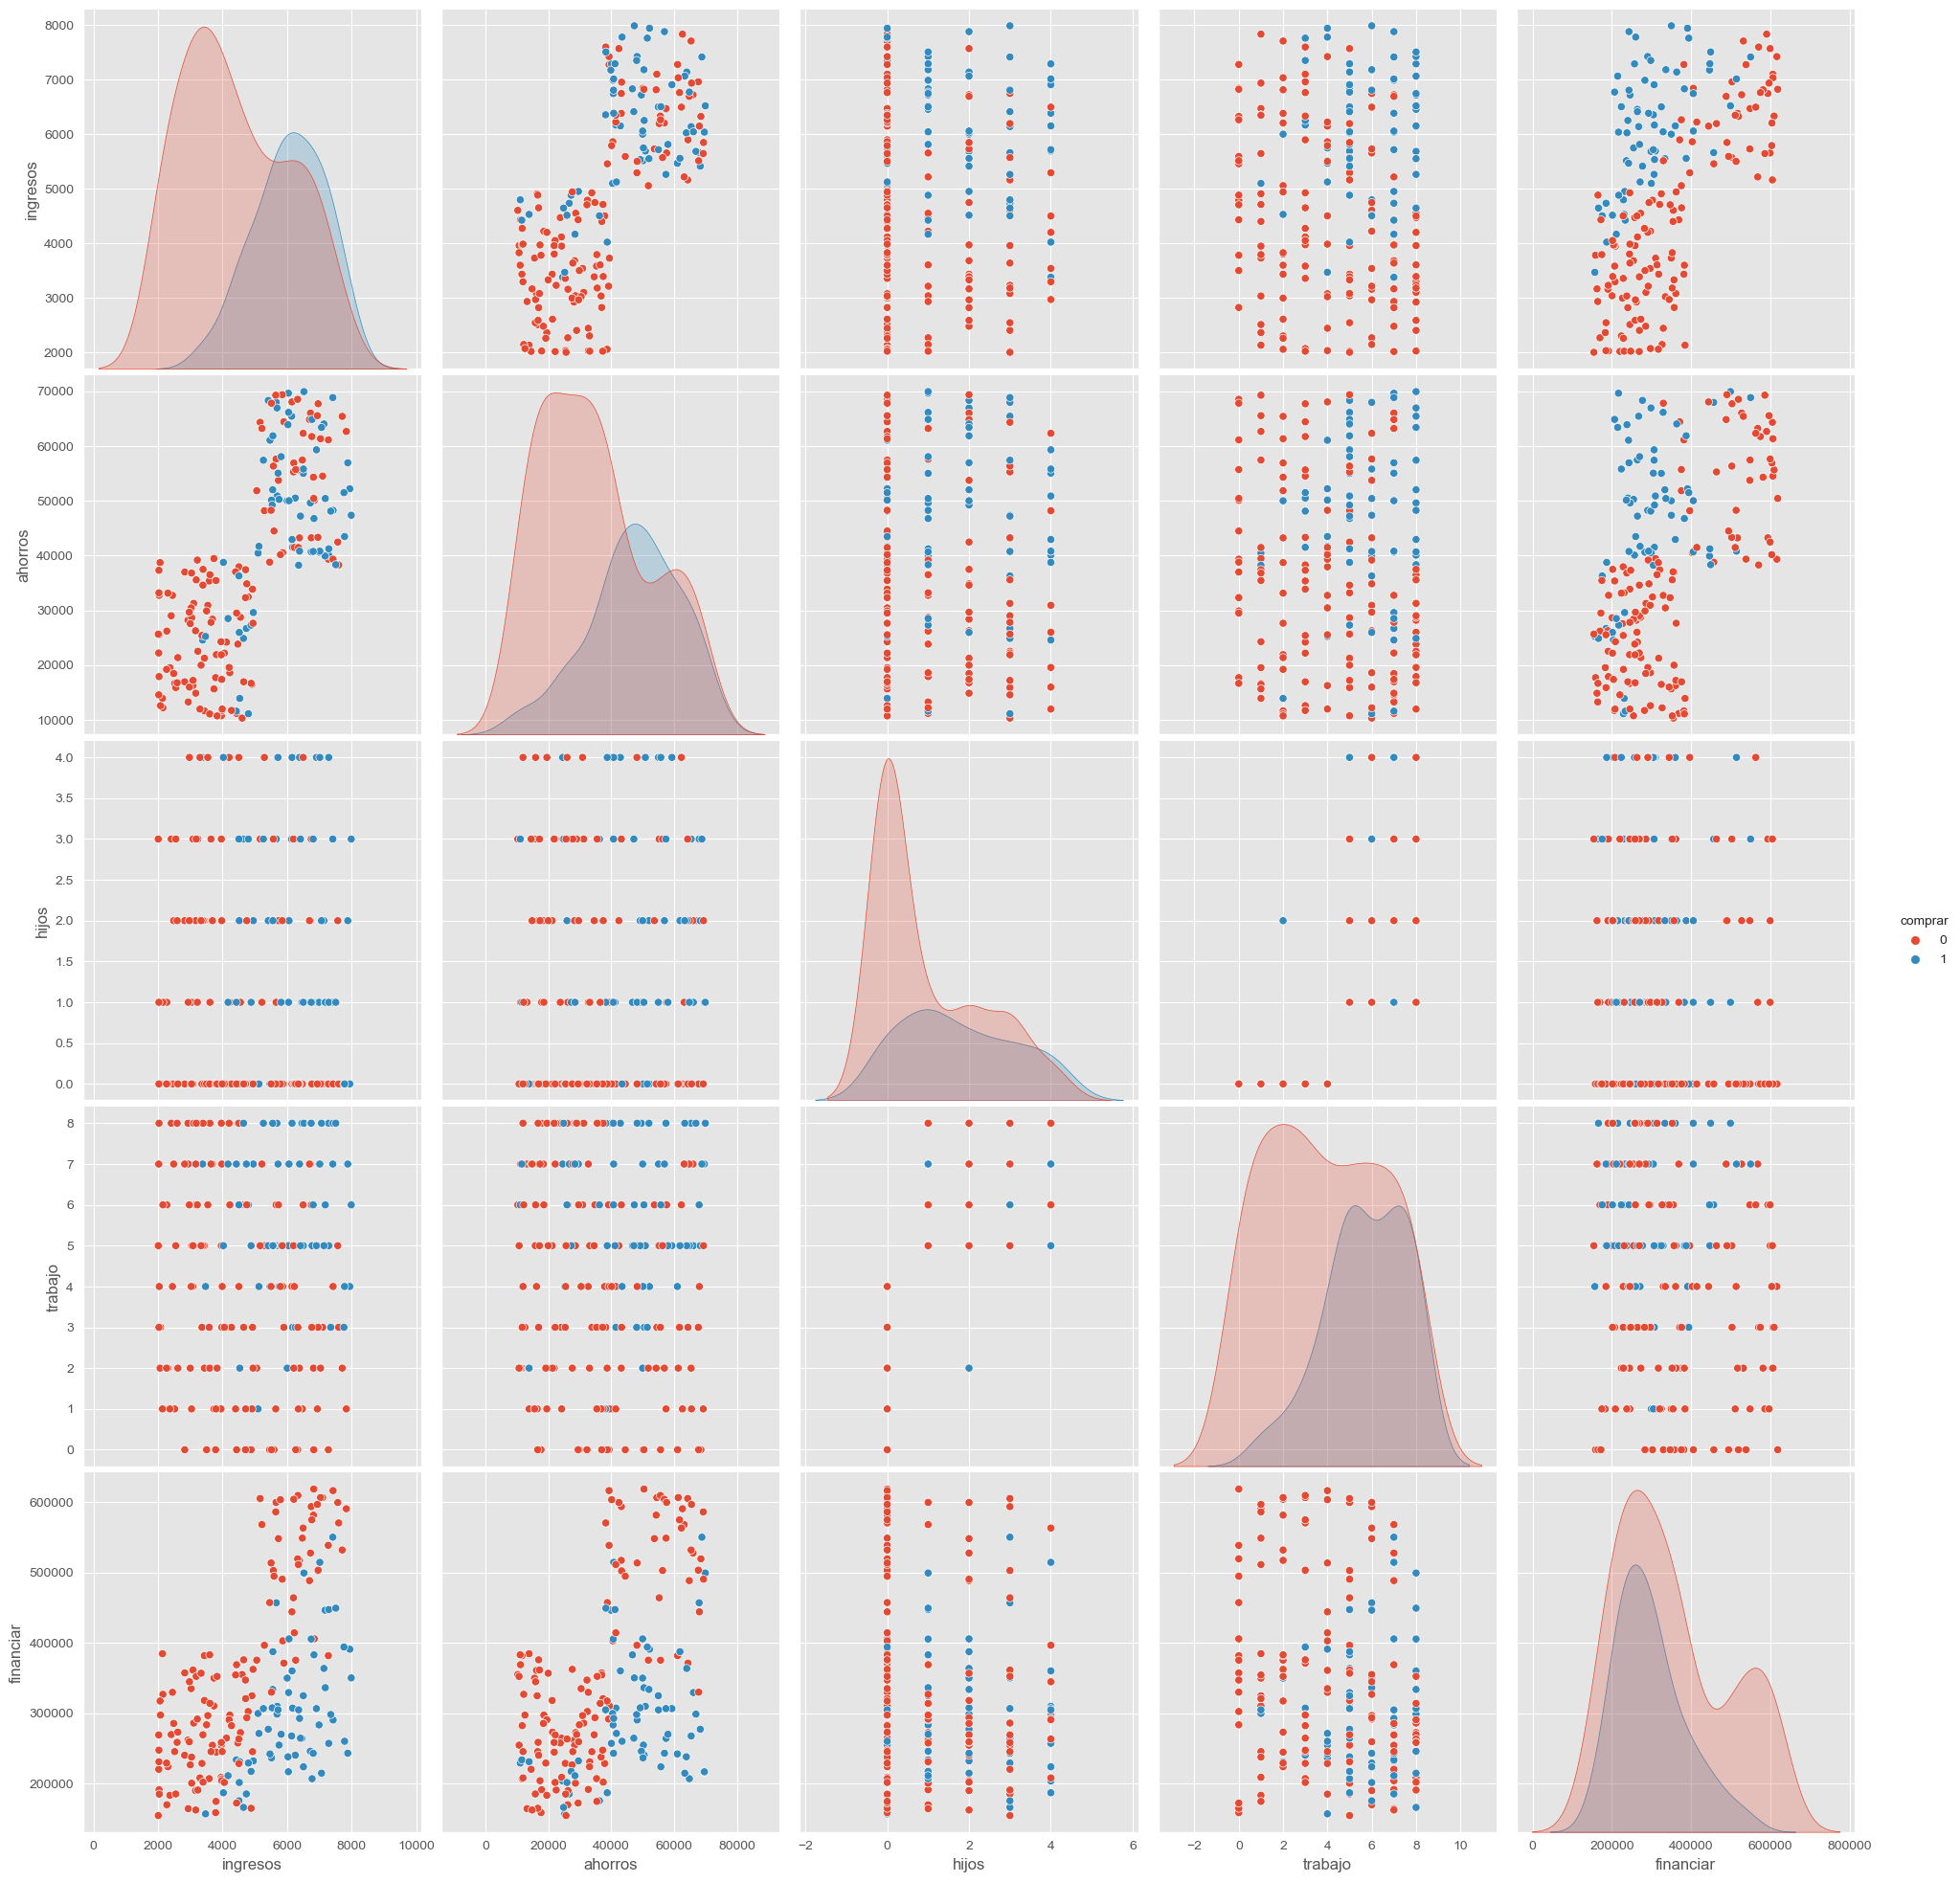

In [11]:
sb.pairplot(dataframe, hue='comprar',height=4,vars=used_features,kind='scatter')

### Ejemplo: Graficar 2 de las Características

[(2000.0, 9000.0), (100000.0, 700000.0)]

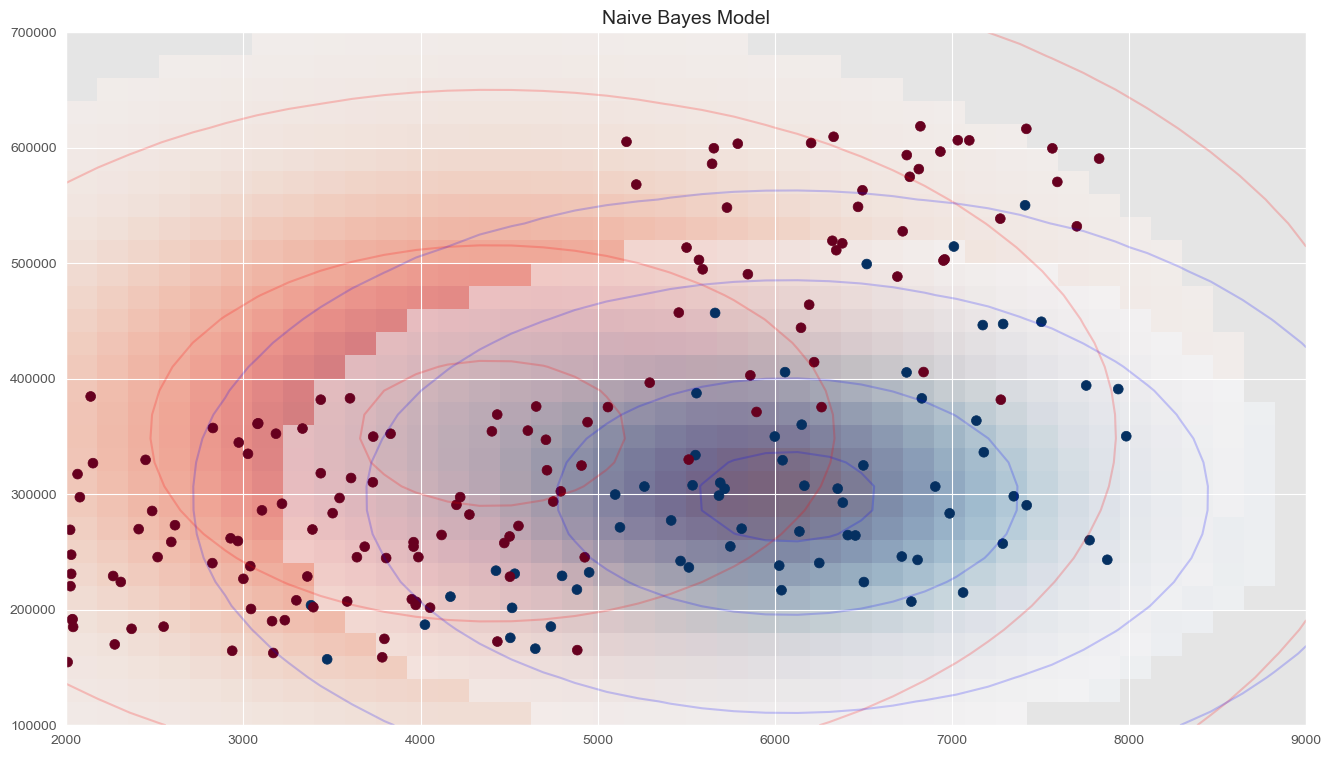

In [12]:
used_features2 =[
    "ingresos",
    "financiar"
]
X=dataframe[used_features2].values
y=dataframe["comprar"]

fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (2000, 9000)
ylim = (100000, 700000)

xg = np.linspace(xlim[0], xlim[1], 40)
yg = np.linspace(ylim[0], ylim[1], 30)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

Vemos que cuantos más ingresos tiene la familia y menor es la cantidad a financiar, mejora la opción de Comprar (en azul). De otra manera, convendrá alquilar (rojo)

# Creamos el modelo de Gaussian Naive Bayes

Dividimos en un set de Entrenamiento y otro de Test con el 20% de las entradas

In [13]:
# Split dataset in training and test datasets
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=6) 
y_train =X_train["comprar"]
y_test = X_test["comprar"]

Entrenamos el modelo

In [14]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    y_train
)
y_pred = gnb.predict(X_test[used_features])

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


# Resultados

In [15]:
print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train[used_features], y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(gnb.score(X_test[used_features], y_test))) 

Precisión en el set de Entrenamiento: 0.87
Precisión en el set de Test: 0.90


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


In [16]:
# Print Test results
print("Total de Muestras en Test: {}\nFallos: {}"
      .format(
          X_test.shape[0],
          (y_test != y_pred).sum()
))

Total de Muestras en Test: 41
Fallos: 4


In [17]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[24  0]
 [ 4 13]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       1.00      0.76      0.87        17

    accuracy                           0.90        41
   macro avg       0.93      0.88      0.89        41
weighted avg       0.92      0.90      0.90        41


## Nuevas Predicciones

Hagamos 2 pruebas a modo de ejemplo en las que el algoritmo nos recomienda Alquilar (0) y Comprar (1) en el 2do caso

In [18]:
#                 ['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar']
print(gnb.predict([[2000,        5000,     0,       5,         200000],
                   [6000,        34000,    2,       5,         320000] ]))
#Resultado esperado 0-Alquilar, 1-Comprar casa

[0 1]


**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).